<a href="https://colab.research.google.com/github/nandomachado98/NLP-streaming-reviews/blob/main/NLP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
     |████████████████████████████████| 212 kB 48.8 MB/s 


In [4]:
#importação dos pacotes necessários

import nlp
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import seaborn as sns

## Utilizaremos uma base de Reviews de Streamings Onlines da Rotten Tomatoes.

### O primeiro objetivo é construir um modelo de classificação de reviews, que consiga os classificar entre negativos, positivos e neutros.

In [5]:
#importação da base

from google.colab import files
 
 
uploaded = files.upload()

Saving audience_reviews.csv to audience_reviews.csv


### A base contém três colunas:
1.   Show (nome do seriado)
2.   Rating (nota de 0 a 5)
3.   Review, o comentário do usuário

Trataremos de criar uma nova coluna que classifica o Rating em:
*   Positivo
*   Neutro
*   Negativo

Classificando o Rating em (0 - 2.5 = 'negativo', 2.5 - 3.5 = 'neutro', > 3.5 = 'positivo'.



In [ ]:
# a nossa base sera o df de treino

train_df = pd.read_csv("./audience_reviews.csv")
train_df.head()

,Show,Rating,Review
0,Test,0.0,Test review
1,Loot,2.5,"I love the stars, but the show is riddled with..."
2,Loot,4.5,Great show to watch. It's something that's eas...
3,Loot,0.5,Another Apple tanker crashes into the reef wit...
4,Loot,4.5,"This is such a fun, endearing show. It has a ..."


In [ ]:
# Criação de coluna adicional, que chamaremos de Etiqueta

def nps(row):
  if row <= 2.5:
    return 'negativo'
  if row <= 3.5:
    return 'neutro'
  if row <=5:
    return 'postivo'

train_df['etiqueta'] = train_df['Rating'].apply(lambda x: nps(x))
train_df.head()

,Show,Rating,Review,etiquieta,etiqueta
0,Test,0.0,test review,negativo,negativo
1,Loot,2.5,"love star , show riddl clich charact comedi be...",negativo,negativo
2,Loot,4.5,great show watch . 's someth 's easi light hea...,postivo,postivo
3,Loot,0.5,anoth appl tanker crash reef amaz talent stori...,negativo,negativo
4,Loot,4.5,"fun , endear show . lot littl joke bake feel c...",postivo,postivo


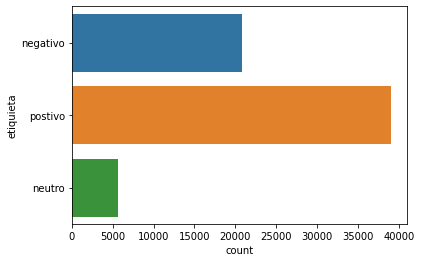

In [ ]:
# Vamos checar quantas classificações temos em cada etiqueta

import seaborn as sns

sns.countplot(y='etiqueta', data=train_df)

**Fazendo a codificação dos valores de etiqueta para cada valor na base de treino**

In [ ]:
le = LabelEncoder()
Y = le.fit_transform(train_df['etiqueta'])

In [ ]:
Y

array([0, 0, 2, ..., 0, 2, 0])

In [ ]:
le.classes_

array(['negativo', 'neutro', 'postivo'], dtype=object)

**Separando as bases de treino e teste, com uma amostra de 20% para os testes**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_df['Review'], Y, test_size=0.2, random_state=5)

**Representação TF-IDF**

In [ ]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('clf', LinearSVC())
])

In [ ]:
# Treinando o modelo

pipeline.fit(x_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('clf', LinearSVC())])

In [ ]:
# Testando o modelo

pred = pipeline.predict(x_test)

In [ ]:
# Acurácia do modelo

accuracy_score(y_test, pred)

0.8434185425410149

### Aqui conseguimos enxergar a precisão do modelo em cada uma das classificações 

*   0: negativo, onde ele acerta 83%
*   1: neutro, onde ele acerta só 42%
*   2: positivo, onde ele acerta 87%)                                                                    
                                                                              

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      4160
           1       0.42      0.15      0.22      1127
           2       0.87      0.94      0.90      7818

    accuracy                           0.84     13105
   macro avg       0.71      0.65      0.66     13105
weighted avg       0.82      0.84      0.82     13105



E aqui temos uma exemplificação do que nosso modelo realiza. A partir de um review, ele atribui uma etiqueta

In [ ]:
text = 'I think the last season of Game of Thrones is terrible, i hate it'

prediction = pipeline.predict({text})
le.inverse_transform(prediction)[0]

'negativo'

In [ ]:
agp = train_df.groupby('Show').count().sort_values('Rating', ascending=False)
agp.head(10)

,Rating,Review,etiquieta
Show,,,
Game of Thrones,3465,3465,3465
Watchmen,2576,2576,2576
The Witcher,2200,2200,2200
WandaVision,1940,1940,1940
Halo,1782,1782,1782
Arcane: League of Legends,1724,1724,1724
The Falcon and the Winter Soldier,1642,1642,1642
Loki,1557,1557,1557
The Book of Boba Fett,1482,1482,1482


## Segundo objetivo: Reconhecimento de Entidades

In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import pandas as pd
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

nltk.download("punkt")  # tokenizador
nltk.download('averaged_perceptron_tagger') # etiquetador

#usamos panda para ler toda a tabela
df = pd.read_csv('./audience_reviews.csv')

#neste laço atrelamos a string sent apenas os dados da coluna "review" que ´o que nos interessa
sent = ' '
for x in df["Review"] :
  sent +=' ' + x

#devido a uma limitação da função nlp que pode analisar um numero finito de caracteres tivemos que cortar nossa string para que a função pudesse lê-la
sent = sent[:len(sent)//21]

pessoas = ['']
sent = nlp(sent)
for ent in sent.ents:
  if(ent.label_ == 'PERSON'):
      pessoas.append(ent.text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [10]:
from collections import Counter

contador = Counter(pessoas)



tabela = pd.DataFrame.from_dict(contador, orient='index').reset_index()


tabela

,index,0
0,,1
1,Maya Rudolph,6
2,Kim Booster,2
3,Ben Platt,1
4,Matt Hubbard,1
...,...,...
855,Soap Operas,1
856,Anson Mount's,2
857,Klingon D6,1
858,D7,1


## Terceiro objetivo: analise de sentimentos das reviews

1 . Remover caracteres especiais

In [ ]:
def is_special(text):
  rem = ''
  for i in text:
    if i.isalnum():
      rem = rem + i
    else:
      rem = rem + ' '
  return rem

  train_df.Review = train_df.Review.apply(is_special)

2 . Converter tudo para minúsculo

In [ ]:
def to_lower(text):
  return text.lower()

train_df.Review = train_df.Review.apply(to_lower)

3 . Remover StopWords

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

def rem_stopwords(text):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  return [w for w in words if w not in stop_words]

train_df.Review = train_df.Review.apply(rem_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


4 . Semming das palavras

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def stem_txt(text):
  ss = SnowballStemmer('english')
  return " ".join([ss.stem(w) for w in text])

train_df.Review = train_df.Review.apply(stem_txt)

In [ ]:
train_df.Review

0                                              test review
1        love star , show riddl clich charact comedi be...
2        great show watch . 's someth 's easi light hea...
3        anoth appl tanker crash reef amaz talent stori...
4        fun , endear show . lot littl joke bake feel c...
                               ...                        
65517                                    outstand inspir .
65518    spent 43 year public school near 30 communiti ...
65519    put rap show ? tri get wide audienc possibl , ...
65520    keep ! ! ! network tv ! ! show like this us ' ...
65521             consid plot , supris offens toward gay .
Name: Review, Length: 65522, dtype: object

### Criando o Modelo

1. Bag of Words (BOW)

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

x = np.array(train_df.iloc[:,0].values)
y = np.array(train_df.etiqueta.values)
cv = CountVectorizer(max_features = 2000)
x = cv.fit_transform(train_df.Review).toarray()

print('x.shape = ', x.shape)
print('y.shape = ', y.shape)

x.shape =  (65522, 2000)
y.shape =  (65522,)


In [ ]:
print(y)

['negativo' 'negativo' 'postivo' ... 'negativo' 'postivo' 'negativo']


2. Divisão Treino e Teste

In [ ]:
trainx, testx, trainy, testy = train_test_split(x,y,test_size=0.2, random_state=9)

print("Train shapes: x = {}, y = {}".format(trainx.shape,trainy.shape))
print("Test shapes: x = {}, y = {}".format(testx.shape,testy.shape))

Train shapes: x = (52417, 2000), y = (52417,)
Test shapes: x = (13105, 2000), y = (13105,)


3. Treinando o modelo os modelos

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

gnb,mnb,bnb = GaussianNB(), MultinomialNB(alpha=1.0,fit_prior=True), BernoulliNB(alpha=1.0,fit_prior=True)

gnb.fit(trainx,trainy)
mnb.fit(trainx,trainy)
bnb.fit(trainx,trainy)

BernoulliNB()

4. Predições e acurácia

In [ ]:
ypg = gnb.predict(testx)
ypm = mnb.predict(testx)
ypb = bnb.predict(testx)

In [ ]:
print("Gaussian = ",accuracy_score(testy,ypg))
print("Multinomial = ",accuracy_score(testy,ypm))
print("Bernoulli = ",accuracy_score(testy,ypb))

Gaussian =  0.6868370850820298
Multinomial =  0.803967951163678
Bernoulli =  0.6956886684471576


In [ ]:
import pickle

pickle.dump(mnb, open('model1.pkl','wb'))

## Utilizando o modelo

In [ ]:
text1 = '''I hate it'''

f1 = is_special(text1)
f2 = to_lower(f1)
f3 = rem_stopwords(f2)
f4 = stem_txt(f3)

bow,words = [], word_tokenize(f4)
for word in words:
  bow.append(words.count(word))

word_dict = cv.vocabulary_
pickle.dump(word_dict,open('model1.pkl','wb'))

inp = []
for i in word_dict:
  inp.append(f4.count(i[0]))
y_pred = mnb.predict(np.array(inp).reshape(1,2000))

In [ ]:
y_pred

array(['negativo'], dtype='<U8')

## Quarto Objetivo: Wordcloud das palavras mais comentadas dos usuários

# Importando Bibliotecas
Para conseguir uma visualização gráfica por *Workcloud*, foi necessário a importação da biblioteca NLTK:

In [ ]:
import nltk
import numpy as np
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Dados
Como o foco é demonstrar apenas o texto com os *Reviews*, ou seja, apenas os comentários, então pegamos a coluna desejada à partir do seguinte código:

In [ ]:
print(train_df['Review'])

0                                              Test review
1        I love the stars, but the show is riddled with...
2        Great show to watch. It's something that's eas...
3        Another Apple tanker crashes into the reef wit...
4        This is such a fun, endearing show.  It has a ...
                               ...                        
65517                           outstanding and inspiring.
65518    Having spent 43 years in public schools and ne...
65519    why did they have to put rap in the show? If y...
65520    keep it up!!! NETWORK TV!! Shows like this and...
65521    Considering the plot, its suprisingly offensiv...
Name: Review, Length: 65522, dtype: object


# Classificação de Texto (Stopwords)
Foi necessário **Classificar o Texto** e para melhorar a visualização, e consequentemente, a análise das palavras mais frequentes, removemos as *Stopwords* com o seguinte código:

In [ ]:
from wordcloud.wordcloud import STOPWORDS
from nltk.stem.snowball import stopwords
words = train_df['Review']
all_words = " ".join(w for w in words)
stopwords = set(STOPWORDS)

# WordCloud
A princípio, vamos definir uma função que irá plotar nossa wordcloud. Em seguida, vamos usar a biblioteca wordcloud para gerar nossa nuvem de palavras.

In [ ]:
def plot_wordcloud(wc):
  fig, ax = plt.subplots(figsize=(14,7))
  ax.imshow(wc,interpolation='bilinear')
  ax.set_axis_off()
  plt.imshow(wc)

In [ ]:
wc = WordCloud(stopwords=stopwords,
               background_color='black',
               width=1600,
               height=1200).generate(all_words)

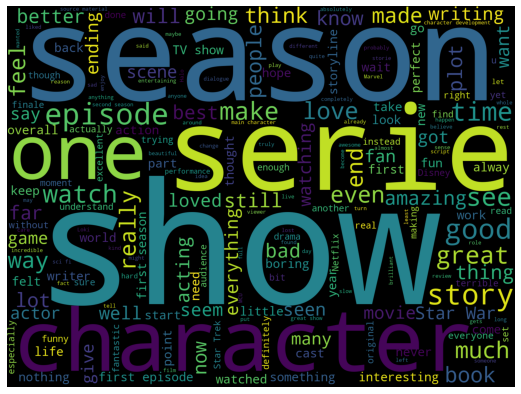

In [ ]:
plot_wordcloud(wc)

# Análise Específica
Para realizar uma análise sobre um tema específico, exemplificamos com uma série, no caso "Loki". Com a visualização da *WordCloud*, percebemos que as principais palavras encontradas nos comentários são **Positivas**, ou seja, bem avaliada pelos usuários da plataforma.

In [ ]:
words = train_df[train_df['Show']=='Loki']['Review']
all_words = " ".join(w for w in words)
stopwords = set(STOPWORDS)

In [ ]:
wc = WordCloud(stopwords=stopwords,
               background_color='black',
               width=1600,
               height=1200).generate(all_words)

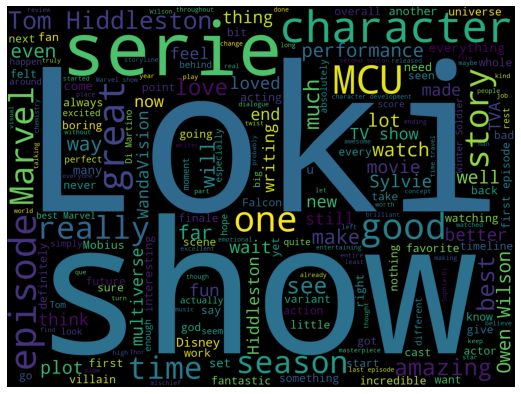

In [ ]:
plot_wordcloud(wc)